In [1]:
import numpy as np
import pandas as pd
import keras
import timeit
import copy 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM,CuDNNGRU
from keras.layers import LeakyReLU,concatenate
from keras.models import Model
from keras.layers import Input,Dense, Dropout, Activation,LSTM,GRU,Conv2D,Flatten,MaxPooling2D,BatchNormalization
from keras.regularizers import l1,l2,l1_l2
from keras.constraints import NonNeg
import gc
from random import shuffle
from keras.layers import TimeDistributed
from sklearn.externals import joblib 
import scipy as sp
import cv2
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
# Definitions
batch_size = 100
total_samples = 62900
height=32
width=48


total_steps = int(total_samples/batch_size)
#lines_to_read=10000000

data_dir = "/home/slow-storage/Kaggle/Earthquake/"
train_dir = data_dir + "images/"

modeltype = "cnn"


In [3]:
#Load Labels
traindf = pd.read_csv(labels_file,names=['time_to_failure'])

y = traindf['time_to_failure'].to_numpy()

y = y.reshape(-1, 1)

print(sp.stats.describe(y))

#scaler = MinMaxScaler()
scaler = StandardScaler()

y = scaler.fit_transform(y)

# Scale Labels

del traindf
print(y.shape)
print(total_steps)

DescribeResult(nobs=62900, minmax=(array([9.5753262e-05]), array([16.10739954])), mean=array([5.67952933]), variance=array([13.48877531]), skewness=array([0.45626236]), kurtosis=array([-0.53766369]))
(62900, 1)
629


In [4]:
print(y)
print(sp.stats.describe(y))

[[-1.15684865]
 [-1.15771926]
 [-1.1582916 ]
 ...
 [ 1.11272146]
 [ 1.11185084]
 [ 1.11125128]]
DescribeResult(nobs=62900, minmax=(array([-1.54640134]), array([2.83930998])), mean=array([4.69929695e-17]), variance=array([1.0000159]), skewness=array([0.45626236]), kurtosis=array([-0.53766369]))


In [5]:
class EarthquakeImageReader(keras.utils.Sequence):

    def __init__(self, rosa_dir, plot_dir, y, batch_size, gentype,height,width):
        
        self.rosa_dir = rosa_dir
        self.plot_dir = plot_dir
        self.y = y
        self.width=width
        self.height=height
        self.batch_size = batch_size
        self.gentype = gentype
        self.on_epoch_end()
    
    def __len__(self):
        return int(len(self.y)/batch_size)
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(0,self.y.shape[0])

    def __getitem__(self,index):
        
        start = index*self.batch_size
        end = (index+1)*self.batch_size

        image_placeholders = np.arange(start,end)
        
        x1 = np.array([])
        x1 = np.zeros((len(image_placeholders),self.height,self.width,3))

        x2 = np.array([])
        x2 = np.zeros((len(image_placeholders),self.height,self.width,3))       
        
        counter = 0
        
        for i in image_placeholders:
            #read the image
            rosa_image = cv2.imread(self.rosa_dir + str(i) + ".png",1)
            plot_image = cv2.imread(self.plot_dir + str(i) + ".png",1)
            
            #resize the image
            new_rosa_img = cv2.resize(rosa_image,(self.width,self.height))
            new_plot_img = cv2.resize(plot_image,(self.width,self.height))
            
            # Add to array
            x1[counter] = new_rosa_img/255
            x2[counter] = new_plot_img/255
            
            counter+=1
        
        if self.gentype == "train":
            y = self.y[start:end]
            return [x1,x2],y
        
        

In [6]:
train_gen = EarthquakeImageReader(rosa_dir,plot_dir,y,batch_size,"train",height,width)

In [7]:
print(type(train_gen))

<class '__main__.EarthquakeImageReader'>


In [8]:
def build_CNN():
    
    inputA = Input(shape=(height,width,3))
    inputB = Input(shape=(height,width,3))
    
    x = Conv2D(128,kernel_size=3)(inputA)
    x = LeakyReLU(alpha=0.3)(x)
    
    x = Conv2D(64,kernel_size=3)(x)
    x = LeakyReLU(alpha=0.3)(x)
    
    x = Conv2D(48,kernel_size=2)(x)
    x = LeakyReLU(alpha=0.3)(x)
    
    x = Conv2D(34,kernel_size=2)(x)
    x = LeakyReLU(alpha=0.3)(x)
    
    x = Conv2D(28,kernel_size=1)(x)
    x = LeakyReLU(alpha=0.3)(x)
    
    x = Flatten()(x)
    x = Model(inputs=inputA, outputs=x)
 
    y = Conv2D(128,kernel_size=3)(inputB)
    y = LeakyReLU(alpha=0.3)(y)
    
    y = Conv2D(64,kernel_size=3)(y)
    y = LeakyReLU(alpha=0.3)(y)
    
    y = Conv2D(48,kernel_size=2)(y)
    y = LeakyReLU(alpha=0.3)(y)
    
    y = Conv2D(34,kernel_size=2)(y)
    y = LeakyReLU(alpha=0.3)(y)
    
    y = Conv2D(28,kernel_size=1)(y)
    y = LeakyReLU(alpha=0.3)(y)
    
    y = Flatten()(y)
    y = Model(inputs=inputB, outputs=y)
    
    combined = concatenate([x.output, y.output])

    z = Dense(512,activation='relu')(combined)
    z = LeakyReLU(alpha=0.3)(z)
    
    z = Dense(256,activation='relu')(z)
    z = LeakyReLU(alpha=0.3)(z)
    
    z = Dense(16,activation='relu')(z)
    z = LeakyReLU(alpha=0.3)(z)
    
    z = Dense(1, activation="linear")(z)
    
    model = Model(inputs=[x.input, y.input], outputs=z)
    
    return model

In [9]:
if modeltype == "cnn":
    model = build_CNN()

    
optim = Adam(lr = 0.001)

model.compile(loss='mse', optimizer=optim,metrics=['mae','mse'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 48, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 48, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 46, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 30, 46, 128)  3584        input_2[0][0]                    
_____________________________________

In [10]:
best_model = data_dir + modeltype + '_weights_best.hdf5'
current_model = data_dir + modeltype + '_weights_current.hdf5'



checkpoint = ModelCheckpoint(best_model, 
                             monitor="loss",
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')


callbacks_list = [checkpoint]


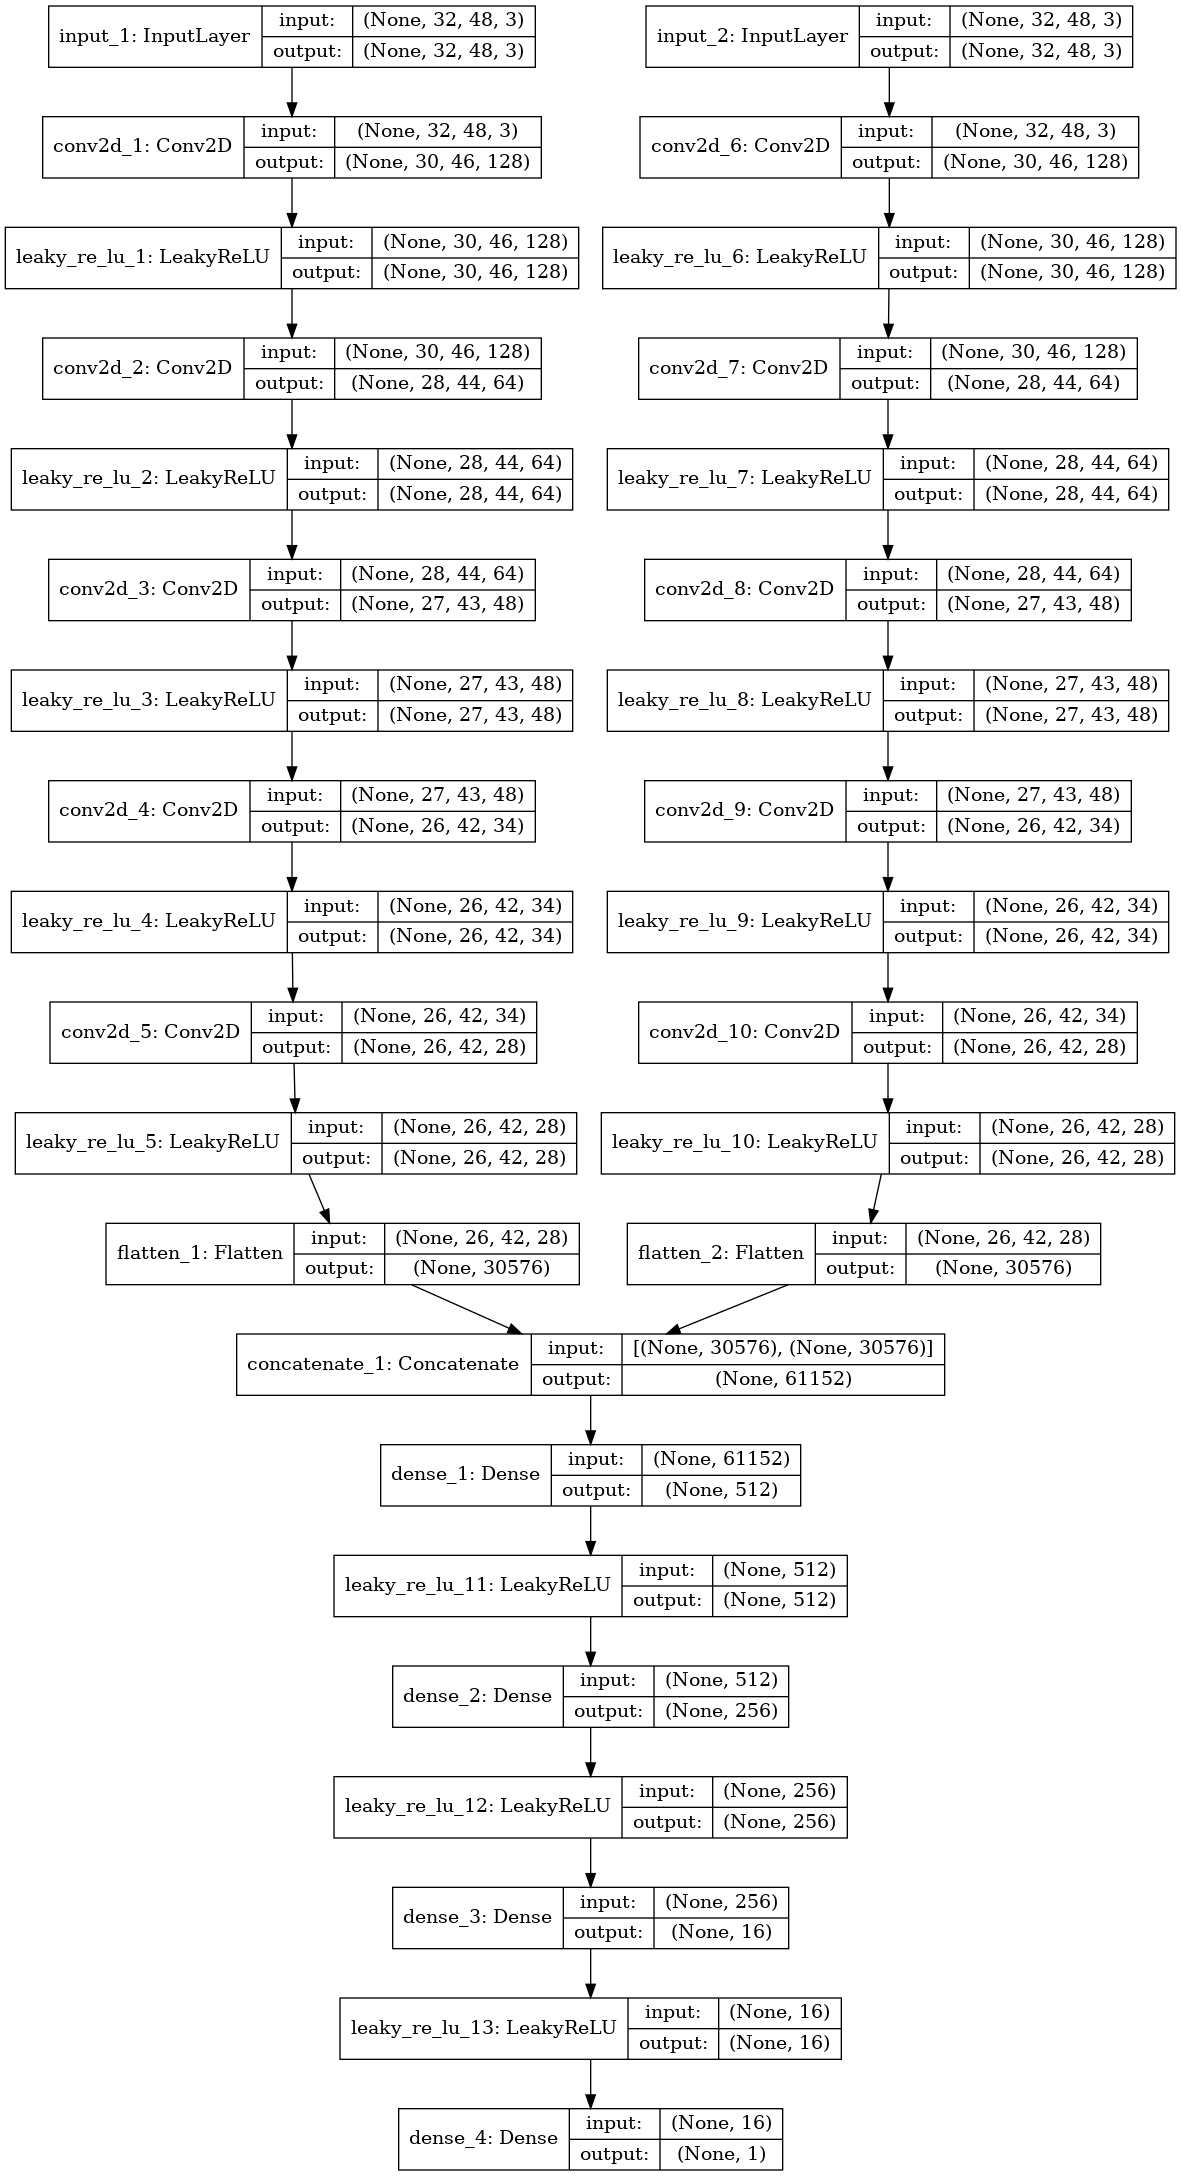

In [11]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [12]:
#model.load_weights(best_model)
print("Train Size:", total_steps)

history = model.fit_generator(train_gen,
                    steps_per_epoch=total_steps, 
                    epochs=300,
                    verbose=1,
                    shuffle=True,
                    max_queue_size=2000,
                    #initial_epoch=12,
                    #pickle_safe=True,
                    use_multiprocessing=False,    
                    workers=3,         
                    callbacks=callbacks_list
                   )

# 10 Epochs:0.82760

Train Size: 629
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
629/629 [==============================] - 263s 418ms/step - loss: 1.4428 - mean_absolute_error: 0.8972 - mean_squared_error: 1.4428

Epoch 00001: loss improved from inf to 1.44283, saving model to /home/slow-storage/Kaggle/Earthquake/cnn_weights_best.hdf5
Epoch 2/300
629/629 [==============================] - 263s 418ms/step - loss: 1.0009 - mean_absolute_error: 0.8304 - mean_squared_error: 1.0009

Epoch 00002: loss improved from 1.44283 to 1.00092, saving model to /home/slow-storage/Kaggle/Earthquake/cnn_weights_best.hdf5
Epoch 3/300
629/629 [==============================] - 260s 413ms/step - loss: 1.0009 - mean_absolute_error: 0.8305 - mean_squared_error: 1.0009

Epoch 00003: loss improved from 1.00092 to 1.00091, saving model to /home/slow-storage/Kaggle/Earthquake/cnn_weights_best.hdf5
Epoch 4/300
629/629 [==============================] - 260s 414ms/step - loss: 1.0008 - mean_absolute_error: 0.8304 - mea


Epoch 00039: loss did not improve from 1.00057
Epoch 40/300
629/629 [==============================] - 259s 412ms/step - loss: 1.0008 - mean_absolute_error: 0.8302 - mean_squared_error: 1.0008

Epoch 00040: loss did not improve from 1.00057
Epoch 41/300
629/629 [==============================] - 259s 412ms/step - loss: 1.0009 - mean_absolute_error: 0.8302 - mean_squared_error: 1.0009

Epoch 00041: loss did not improve from 1.00057
Epoch 42/300
629/629 [==============================] - 259s 411ms/step - loss: 1.0009 - mean_absolute_error: 0.8306 - mean_squared_error: 1.0009

Epoch 00042: loss did not improve from 1.00057
Epoch 43/300
629/629 [==============================] - 260s 413ms/step - loss: 1.0007 - mean_absolute_error: 0.8299 - mean_squared_error: 1.0007

Epoch 00043: loss did not improve from 1.00057
Epoch 44/300
629/629 [==============================] - 259s 412ms/step - loss: 1.0006 - mean_absolute_error: 0.8307 - mean_squared_error: 1.0006

Epoch 00044: loss did not imp

629/629 [==============================] - 258s 410ms/step - loss: 1.0008 - mean_absolute_error: 0.8304 - mean_squared_error: 1.0008

Epoch 00082: loss did not improve from 1.00057
Epoch 83/300
629/629 [==============================] - 258s 411ms/step - loss: 1.0010 - mean_absolute_error: 0.8311 - mean_squared_error: 1.0010

Epoch 00083: loss did not improve from 1.00057
Epoch 84/300
629/629 [==============================] - 258s 411ms/step - loss: 1.0008 - mean_absolute_error: 0.8300 - mean_squared_error: 1.0008

Epoch 00084: loss did not improve from 1.00057
Epoch 85/300
629/629 [==============================] - 258s 410ms/step - loss: 1.0009 - mean_absolute_error: 0.8306 - mean_squared_error: 1.0009

Epoch 00085: loss did not improve from 1.00057
Epoch 86/300
629/629 [==============================] - 258s 411ms/step - loss: 1.0011 - mean_absolute_error: 0.8300 - mean_squared_error: 1.0011

Epoch 00086: loss did not improve from 1.00057
Epoch 87/300
629/629 [=====================

KeyboardInterrupt: 

In [ ]:
model.save_weights(current_model)

In [15]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()


<Figure size 640x480 with 1 Axes>

In [12]:
import os
files = os.listdir(test_rosa_dir)
files.sort() 


model.load_weights(best_model)

final_pred = {}
f=open(data_dir+"submission.csv","w+")

f.write("seg_id,time_to_failure\n")

for file in files:
    #read the images
    rosa_image = cv2.imread(test_rosa_dir + file,1)
    plot_image = cv2.imread(test_plot_dir + file,1)
            
    #resize the images
    new_rosa_img = cv2.resize(rosa_image,(width,height))
    new_plot_img = cv2.resize(plot_image,(width,height))
    
    
    #Create Array and Add Rosa
    x1 = np.array([])
    x1 = np.zeros((1,height,width,3))
    x1[0] = new_rosa_img/255
    
    # Create Array and Add Plot
    x2 = np.array([])
    x2 = np.zeros((1,height,width,3))
    x2[0] = new_plot_img/255
    
    id=os.path.splitext(file)[0]
    
    prediction = model.predict([x1,x2])
    prediction= scaler.inverse_transform(prediction)
    
    print(id+","+str(prediction[0][0]))
    f.write(id+","+str(prediction[0][0])+"\n")
    
f.close()

seg_00030f,5.6647186
seg_0012b5,5.6647186
seg_00184e,5.6647186
seg_003339,5.6647186
seg_0042cc,5.6647186
seg_004314,5.6647186
seg_004cd2,5.6647186
seg_004ee5,5.6647186
seg_004f1f,5.6647186
seg_00648a,5.6647186
seg_006e4a,5.6647186
seg_007a37,5.6647186
seg_00a37e,5.6647186
seg_00be11,5.6647186
seg_00c35b,5.6647186
seg_00cc91,5.6647186
seg_00e5f7,5.6647186
seg_00f3b9,5.6647186
seg_010eab,5.6647186
seg_0125d9,5.6647186
seg_0144cb,5.6647186
seg_0165c6,5.6647186
seg_016913,5.6647186
seg_016cdb,5.6647186
seg_017314,5.6647186
seg_01a8dc,5.6647186
seg_01c775,5.6647186
seg_01ecb0,5.6647186
seg_02042f,5.6647186
seg_025e78,5.6647186
seg_032822,5.6647186
seg_0339ca,5.6647186
seg_037461,5.6647186
seg_038879,5.6647186
seg_03d386,5.6647186
seg_03d63e,5.6647186
seg_03d680,5.6647186
seg_03f380,5.6647186
seg_0445d7,5.6647186
seg_046c28,5.6647186
seg_0488a1,5.6647186
seg_049957,5.6647186
seg_04a696,5.6647186
seg_04ae38,5.6647186
seg_04b87a,5.6647186
seg_04cceb,5.6647186
seg_04ee93,5.6647186
seg_04fd93,5.

seg_29022f,5.6647186
seg_2916e3,5.6647186
seg_293dbf,5.6647186


KeyboardInterrupt: 